# SkillFactory
## Введение в ML, введение в sklearn

В этом задании мы с вами рассмотрим данные с конкурса [Задача предсказания отклика клиентов ОТП Банка](http://www.machinelearning.ru/wiki/index.php?title=%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D1%82%D0%BA%D0%BB%D0%B8%D0%BA%D0%B0_%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2_%D0%9E%D0%A2%D0%9F_%D0%91%D0%B0%D0%BD%D0%BA%D0%B0_%28%D0%BA%D0%BE%D0%BD%D0%BA%D1%83%D1%80%D1%81%29)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

### Грузим данные

Считаем описание данных

In [2]:

df_descr = pd.read_csv('data/otp_description.csv', sep='\t', encoding='utf8')

In [3]:
for i in range(df_descr.shape[0]):
    print(df_descr.iloc[i,0], "-", df_descr.iloc[i,1])

AGREEMENT_RK - уникальный идентификатор объекта в выборке
AGE - возраст клиента
SOCSTATUS_WORK_FL - социальный статус клиента относительно работы (1 - работает, 0 - не работает)
SOCSTATUS_PENS_FL - социальный статус клиента относительно пенсии (1 - пенсионер, 0 - не пенсионер)
GENDER - пол клиента (1- женщины, 0-мужчины)
CHILD_TOTAL - количество детей клиента
DEPENDANTS - количество иждивенцев клиента
EDUCATION - образование
MARITAL_STATUS - семейное положение
GEN_INDUSTRY - отрасль работы клиента
GEN_TITLE - должность
ORG_TP_STATE - форма собственности компании
ORG_TP_FCAPITAL - отношение к иностранному капиталу
JOB_DIR - направление деятельности в нутри компании
FAMILY_INCOME - семейный доход (несколько категорий)
PERSONAL_INCOME - личный доход клиента (в рублях)
REG_ADDRESS_PROVINCE - область регистрации клиента
FACT_ADDRESS_PROVINCE - область фактического пребывания клиента
POSTAL_ADDRESS_PROVINCE - почтовый адрес область
TP_PROVINCE - область торговой точки, где клиент брал послед

Считаем обучающую выборки и тестовую (которую мы как бы не видим)

In [4]:
df_train = pd.read_csv('data/otp_train.csv', sep='\t', encoding='utf8')

In [5]:
df_train.shape

(15223, 52)

In [6]:
df_test = pd.read_csv('data/otp_test.csv', sep='\t', encoding='utf8')

In [7]:
df_test.shape

(14910, 52)

## Объединим две выборки

Так как пока мы пока не умеем работать sklearn  Pipeline, то для того, чтобы после предобработки столбцы в двух выборках находились на своих местах.

Для того, чтобы в дальнейшем отделить их введем новый столбец "sample"

In [8]:
df_train.loc[:, 'sample'] = 'train'
df_test.loc[:, 'sample'] = 'test'

In [9]:
df = df_test.append(df_train).reset_index(drop=True)

In [10]:
df.shape

(30133, 53)

In [11]:
p = df.pivot_table(
    'AGREEMENT_RK', 'sample', 'TARGET', 'count')
p

TARGET,0,1
sample,,
test,13160,1750
train,13411,1812


### Чуть-чуть посмотрим на данные

Посмотрим типы данных и их заполняемость

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30133 entries, 0 to 30132
Data columns (total 53 columns):
AGREEMENT_RK                  30133 non-null int64
TARGET                        30133 non-null int64
AGE                           30133 non-null int64
SOCSTATUS_WORK_FL             30133 non-null int64
SOCSTATUS_PENS_FL             30133 non-null int64
GENDER                        30133 non-null int64
CHILD_TOTAL                   30133 non-null int64
DEPENDANTS                    30133 non-null int64
EDUCATION                     30133 non-null object
MARITAL_STATUS                30133 non-null object
GEN_INDUSTRY                  27420 non-null object
GEN_TITLE                     27420 non-null object
ORG_TP_STATE                  27420 non-null object
ORG_TP_FCAPITAL               27425 non-null object
JOB_DIR                       27420 non-null object
FAMILY_INCOME                 30133 non-null object
PERSONAL_INCOME               30133 non-null object
REG_ADDRESS_PRO

Видим, что часть данных - object, скорее всего стоки.


Давайте выведем эти значения для каждого столбца

In [13]:
for i in df_train.columns: # перебираем все столбцы
    if str(df_train[i].dtype) == 'object': # если тип столбца - object
        print('='*10)
        print(i) # выводим название столбца
        print(set(df_train[i])) # выводим все его значения (но делаем set - чтоб значения не повторялись)
        print('\n') # выводим пустую строку

EDUCATION
{'Неполное среднее', 'Два и более высших образования', 'Ученая степень', 'Высшее', 'Неоконченное высшее', 'Среднее', 'Среднее специальное'}


MARITAL_STATUS
{'Вдовец/Вдова', 'Гражданский брак', 'Не состоял в браке', 'Разведен(а)', 'Состою в браке'}


GEN_INDUSTRY
{nan, 'Строительство', 'СМИ/Реклама/PR-агенства', 'Недвижимость', 'Сборочные производства', 'Юридические услуги/нотариальные услуги', 'Нефтегазовая промышленность', 'Маркетинг', 'Коммунальное хоз-во/Дорожные службы', 'Государственная служба', 'Транспорт', 'Банк/Финансы', 'Здравоохранение', 'Наука', 'Страхование', 'Подбор персонала', 'Образование', 'Другие сферы', 'Логистика', 'Энергетика', 'Информационные услуги', 'Управляющая компания', 'Торговля', 'Туризм', 'Ресторанный бизнес/Общественное питание', 'Химия/Парфюмерия/Фармацевтика', 'ЧОП/Детективная д-ть', 'Салоны красоты и здоровья', 'Сельское хозяйство', 'Информационные технологии', 'Металлургия/Промышленность/Машиностроение', 'Развлечения/Искусство'}


GEN_TITLE


Mожно заметить что некоторые переменные, которые обозначены как строки (например PERSONAL_INCOME) на самом деле числа, но по какой-то причине были распознаны как строки

Причина же что использовалась запятая для разделения не целой части числа..

Перекодировать их можно например так:

In [14]:
df['PERSONAL_INCOME'].map(lambda x: x.replace(',', '.')).astype('float')

0         7000.0
1         4100.0
2        40000.0
3        20000.0
4        17000.0
5         7000.0
6        10000.0
7         7500.0
8         9000.0
9         4000.0
10       15000.0
11       12000.0
12        8000.0
13       20000.0
14       18500.0
15       14000.0
16        6000.0
17        9000.0
18        5000.0
19       15000.0
20        6100.0
21       22180.0
22        9000.0
23        8700.0
24        7000.0
25        6000.0
26       15000.0
27       12000.0
28       11000.0
29        8000.0
          ...   
30103    12000.0
30104    10000.0
30105    10000.0
30106     8000.0
30107    11000.0
30108     7000.0
30109    10000.0
30110     8000.0
30111    25000.0
30112    10000.0
30113    12000.0
30114     7000.0
30115    12000.0
30116    14500.0
30117    12000.0
30118     8000.0
30119     7000.0
30120    10000.0
30121    10000.0
30122    10000.0
30123    15000.0
30124     8100.0
30125     9500.0
30126    13000.0
30127    10000.0
30128    12000.0
30129    10000.0
30130     6000

Такой эффект наблюдается в столбцах `PERSONAL_INCOME`, `CREDIT`, `FST_PAYMENT`, `LOAN_AVG_DLQ_AMT`, `LOAN_MAX_DLQ_AMT`

### Теперь ваше небольшое исследование

#### Задание 1. Есть ли пропуски в данных? Что с ними сделать?

(единственного верного ответа нет - аргументируйте)

In [15]:
#посчитаем пропуски в данных:
with_null = df.isnull().sum(axis = 0)
with_null[with_null != 0]

GEN_INDUSTRY                   2713
GEN_TITLE                      2713
ORG_TP_STATE                   2713
ORG_TP_FCAPITAL                2708
JOB_DIR                        2713
TP_PROVINCE                     590
REGION_NM                         2
WORK_TIME                      2717
PREVIOUS_CARD_NUM_UTILIZED    29533
dtype: int64

_решение:_ пропуски в данных есть, но способы их заполнения могут зависеть от причин.
для этого рассмотрим пропуски по столбцам отдельно
<br><br>
На сайте сказано, что данные пустые, так как клиенты не заполнили эти поля, но в любом случае нужно проверить на зависимость от других параметром

#### a) Факторы с одинаковым количеством пропусков

У факторов 'GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'JOB_DIR' одинаковое количество пропусков. Проверим, находятся ли пропуски в одних и тех же строках. Например, есть ли в этих факторах не пустые значения, если значение 'GEN_INDUSTRY' пустое

In [16]:
df[df['GEN_INDUSTRY'].isnull() == True][['GEN_INDUSTRY',
                                         'GEN_TITLE',
                                         'ORG_TP_STATE',
                                         'JOB_DIR']].isnull().sum(axis = 0)

GEN_INDUSTRY    2713
GEN_TITLE       2713
ORG_TP_STATE    2713
JOB_DIR         2713
dtype: int64

In [17]:
#создадим отдельный df и посмотрим его подробнее
simult_na = df[df['GEN_INDUSTRY'].isnull() == True]
simult_na.head(n = 15).T

,1,5,8,12,20,28,30,57,77,96,103,111,156,177,192
AGREEMENT_RK,59910420,59911769,59912422,59912574,59913432,59914189,59914517,59918446,59920591,59923652,59924499,59924977,59930509,59932751,59935061
TARGET,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AGE,48,44,53,59,65,63,63,62,58,66,59,61,55,59,63
SOCSTATUS_WORK_FL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SOCSTATUS_PENS_FL,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
GENDER,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1
CHILD_TOTAL,0,2,2,0,2,0,2,0,2,0,0,0,4,2,2
DEPENDANTS,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
EDUCATION,Среднее,Среднее специальное,Среднее специальное,Неполное среднее,Среднее специальное,Среднее специальное,Среднее специальное,Среднее специальное,Среднее специальное,Неполное среднее,Среднее специальное,Среднее специальное,Среднее,Среднее,Неполное среднее
MARITAL_STATUS,Состою в браке,Состою в браке,Состою в браке,Не состоял в браке,Разведен(а),Состою в браке,Не состоял в браке,Состою в браке,Вдовец/Вдова,Состою в браке,Не состоял в браке,Разведен(а),Не состоял в браке,Состою в браке,Разведен(а)


In [18]:
#скорее всего, данные не заполнены для всех неработающих и/или пенсионеров.
#посчитаем к-во записей по столбцам SOCSTATUS_WORK_FL и SOCSTATUS_PENS_FL в
#этом же df

p = simult_na.pivot_table(
    'TARGET', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'count')
p
#получается, что проблема была в отстутствии данных о работе у неработающих
#пенсионеров. При этом безработные в выборке отсутствуют
#также данных по перечисленным факторам нет для одного 24-летнего.
#Предположим, что это ошибка в данных, тогда пропуск можно заполнить
#самыми частыми значениями для его возрастной группы

SOCSTATUS_PENS_FL,0,1
SOCSTATUS_WORK_FL,,
0,NaN,2712.0
1,1.0,NaN


#### b) Фактор worktime

Похоже, пропуски в worktime тоже связаны с неработающими пенсионерами из предыдущего пункта. Однако пропусков там чуть больше, найдем в чем разница

In [19]:
no_worktime = df[df['WORK_TIME'].isnull() == True]
o_worktime = pd.merge(no_worktime, simult_na, how='outer')
i_worktime = pd.merge(no_worktime, simult_na)
set_diff_worktime = pd.concat([o_worktime, i_worktime]).drop_duplicates(keep=False)
#set_diff_worktime.T #в df 4 записи
#есть 4 человека со статусом безработный пенсионер, у которых есть данные о работодателе
#при этом не заполнены данные по времени работы в текущем месте. в остальном
#этот фактор совпадает с 4 предыдущими

#### c) Фактор ORG_TP_FCAPITAL

In [20]:
#скорее всего, пропуски в этом факторе тоже связаны с отсутствием данных по безработным пенсионерам
#поэтому найдем разницу между двумя df с пропусками в этих факторах

no_capital = df[df['ORG_TP_FCAPITAL'].isnull() == True]
o_capital = pd.merge(no_capital, simult_na, how='outer')
i_capital = pd.merge(no_capital, simult_na)
set_diff_capital = pd.concat([o_capital, i_capital]).drop_duplicates(keep=False)
#set_diff_capital.T #7 записей в df

Два множества отличаются на 7 записей. Будем считать, что причина одинаковая

#### d) Фактор TP_PROVINCE

TP_PROVINCE = область торговой точки, где клиент брал последний кредит
из описания данных на сайте не совсем понятно, какие клиенты "лежат" в датасете. Значит ли это, что клиент не брал кредит или что данных нет по какой-то другой причине (например, кредит был получен не в магазине)?

In [21]:
#проверим есть ли нули в поле CREDIT - это может означать, что в выборке есть клиенты без кредитов,
#тогда для них не будет и торговой точки выдачи кредита.
df[df['CREDIT'] == 0]

#в поле с суммами выданных кредитов нет пропусков и нулей

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,...,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,sample


In [22]:
#в датафрейме кроме TP_PROVINCE есть еще 4 фактора, относящихся к географии,
#и 4 фактора, указывающие на совпадение этих измерений (среди них есть и
#совпадение по отсутствующему полю)
#посмотрим этот набор более подробно:

geo_col_list = ['REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE',
               'TP_PROVINCE', 'REGION_NM', 'REG_FACT_FL', 'REG_POST_FL', 'REG_FACT_POST_FL',
               'REG_FACT_POST_TP_FL']

geo_df = df[geo_col_list]
geo_df.head()

,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL
0,Красноярский край,Красноярский край,Красноярский край,Красноярский край,ВОСТОЧНО-СИБИРСКИЙ,0,0,0,1
1,Орловская область,Орловская область,Орловская область,Орловская область,ЦЕНТРАЛЬНЫЙ 1,1,1,1,1
2,Коми,Коми,Коми,Коми,ЦЕНТРАЛЬНЫЙ 2,1,1,1,1
3,Читинская область,Читинская область,Читинская область,Читинская область,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1
4,Хабаровский край,Хабаровский край,Хабаровский край,Хабаровский край,ДАЛЬНЕВОСТОЧНЫЙ,1,1,1,1


In [23]:
#отдельно посмотрим географические факторы с пропусками в TP_PROVINCE
geo_df = geo_df[geo_df['TP_PROVINCE'].isnull() == True]
geo_df

,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL
40,Московская область,Московская область,Московская область,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0
67,Московская область,Московская область,Московская область,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0
120,Московская область,Московская область,Московская область,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0
282,Московская область,Московская область,Московская область,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,0,0,0,0
315,Московская область,Московская область,Московская область,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0
336,Московская область,Московская область,Московская область,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0
534,Московская область,Московская область,Московская область,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0
537,Москва,Москва,Москва,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0
609,Москва,Москва,Москва,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0
664,Московская область,Московская область,Московская область,NaN,ЦЕНТРАЛЬНЫЙ ОФИС,1,1,1,0


In [24]:
#отдельно посмотрим есть ли в логической переменной REG_FACT_POST_TP_FL для TP_PROVINCE единицы

geo_df[geo_df['REG_FACT_POST_TP_FL'] == 1]

,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL


*Ответ на задание 1:* <br>
пропуски есть. основные группы/факторы/причины:<br>
1. __**проблема:**__ есть пропуски для неработающих пенсионеров в 6 столбцах (и совсем небольшое число пропусков там-же, которые можно списать на ошибки при сборе данных<br>
__**решение:**__ можно сделать отдельный "класс" - неработающий пенсионер
2. __**проблема:**__ 590 пропусков TP_PROVINCE - причина пока не ясна. <br>__**решение:**__ Но есть много других географических данных, можно заполнить данными из одного из них для каждого конкретного клиента. Делаем допущение, что часто они совпадают (нужно проверить!!)
3. __**проблема:**__ PREVIOUS_CARD_NUM_UTILIZED <br>__**решение:**__ согласно описанию данных: пропуск = 0. просто заполним

#### Задание 2. Есть ли категориальные признаки? Что с ними делать?

In [25]:
#чтобы найти категориальные признаки - посмотрим к-во уникальных значений в каждом столбце (без учета nan)
distinct_in_cols = {i : df[i].value_counts(dropna = True).count() for i in df.columns}
distinct_in_cols

{'AGE': 47,
 'AGREEMENT_RK': 30133,
 'AUTO_RUS_FL': 2,
 'CHILD_TOTAL': 10,
 'COT_PRESENCE_FL': 2,
 'CREDIT': 12911,
 'DEPENDANTS': 8,
 'DL_DOCUMENT_FL': 1,
 'EDUCATION': 7,
 'FACT_ADDRESS_PROVINCE': 83,
 'FACT_LIVING_TERM': 525,
 'FACT_PHONE_FL': 2,
 'FACT_POST_FL': 2,
 'FAMILY_INCOME': 5,
 'FL_PRESENCE_FL': 2,
 'FST_PAYMENT': 4655,
 'GAR_PRESENCE_FL': 2,
 'GENDER': 2,
 'GEN_INDUSTRY': 31,
 'GEN_PHONE_FL': 2,
 'GEN_TITLE': 12,
 'GPF_DOCUMENT_FL': 2,
 'HS_PRESENCE_FL': 2,
 'JOB_DIR': 10,
 'LAND_PRESENCE_FL': 2,
 'LOAN_AVG_DLQ_AMT': 1942,
 'LOAN_DLQ_NUM': 14,
 'LOAN_MAX_DLQ': 7,
 'LOAN_MAX_DLQ_AMT': 1669,
 'LOAN_NUM_CLOSED': 10,
 'LOAN_NUM_PAYM': 88,
 'LOAN_NUM_TOTAL': 9,
 'MARITAL_STATUS': 5,
 'ORG_TP_FCAPITAL': 2,
 'ORG_TP_STATE': 5,
 'OWN_AUTO': 3,
 'PERSONAL_INCOME': 373,
 'POSTAL_ADDRESS_PROVINCE': 82,
 'PREVIOUS_CARD_NUM_UTILIZED': 2,
 'REGION_NM': 11,
 'REG_ADDRESS_PROVINCE': 82,
 'REG_FACT_FL': 2,
 'REG_FACT_POST_FL': 2,
 'REG_FACT_POST_TP_FL': 2,
 'REG_PHONE_FL': 2,
 'REG_POST_F

In [26]:
#1) в выдорке есть категориальные признаки, уже закодированные в приемлемом для обучения модели виде (1-0):
already_binary = ['AUTO_RUS_FL', 'COT_PRESENCE_FL', 'FL_PRESENCE_FL', 'GAR_PRESENCE_FL', 'GENDER', 'GEN_PHONE_FL',
                 'GPF_DOCUMENT_FL', 'HS_PRESENCE_FL', 'LAND_PRESENCE_FL',
                 'REG_FACT_FL', 'REG_FACT_POST_FL', 'REG_FACT_POST_TP_FL', 'REG_PHONE_FL', 'REG_POST_FL',
                 'SOCSTATUS_PENS_FL', 'SOCSTATUS_WORK_FL', 'FACT_PHONE_FL']

#2) список категориальных признаков:
geo_drop = ['POSTAL_ADDRESS_PROVINCE',
            'REGION_NM',
            'REG_ADDRESS_PROVINCE',
            'TP_PROVINCE',
            'FACT_ADDRESS_PROVINCE']

category_vars = ['EDUCATION', 'FAMILY_INCOME', 'ORG_TP_STATE']

#непонятно LOAN_MAX_DLQ - номер просрочки качественный или нет


#3) есть параметр DL_DOCUMENT_FL, который на всей выборке = 0. Удалим его
#df.drop('DL_DOCUMENT_FL', axis=1, inplace=True)

#категориальные признаки будем кодировать one hot encoding, сначала заполнив пропуски

In [27]:
#"укрупним" часть факторов:


#### Задание 3. Фунция предобработки

Напишите функцию, которая бы

* Удаляло идентификатор `AGREEMENT_RK`
* Избавлялась от проблем с '.' и ',' в стобцах PERSONAL_INCOME, CREDIT, FST_PAYMENT, LOAN_AVG_DLQ_AMT, LOAN_MAX_DLQ_AMT
* Что-то делала с пропусками
* Кодировала категориальные признаки

В результате, ваш датафрейм должен содержать только числа и не содержать пропусков!

In [47]:
from sklearn.preprocessing import StandardScaler
def code_mean(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))

def code_median(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].median()))

def preproc_data(df_input):
    df_output = df_input.copy()
    
    #replace decimal sign
    
    lst_dec_repl = ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']
    
    for i in lst_dec_repl:
        df_output[i] = df_output[i].map(lambda x: x.replace(',', '.')).astype('float32')
        
    #заполняем пропуски
    
    #заполим пропуски для неработающих пенсионеров (потом снова чекнем эти же поля, уже
    #на ошибки в данных, их заполнем по-другому)
    subs_list = ['GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL',
            'JOB_DIR']

    df_output.loc[(df_output['SOCSTATUS_PENS_FL'] == 1)
           & (df_output['SOCSTATUS_WORK_FL'] == 0)
           & (df_output['GEN_INDUSTRY'].isnull() == True), subs_list] = 'unemp_pens'
    
    #после этого останется еще один человек с пропусками в этих полях
    #но в этому случае это скорее всего ошибка, поэтому заполним его
    #пропуски самым частым значением для возраста до 31
    dic_modes = {i : df_output.loc[:,i][df_output['AGE'] <= 30].value_counts().idxmax() for i in subs_list}
    
    for k, v in dic_modes.items():
        df_output.loc[df_output['AGREEMENT_RK'] == 64469089, k] = dic_modes[k]
    
    #заполняем последний пропуск в ORG_TP_FCAPITAL
    df_output.loc[df_output['ORG_TP_FCAPITAL'].isnull() == True, 'ORG_TP_FCAPITAL'] = df_output.loc[:,'ORG_TP_FCAPITAL'].value_counts().idxmax()
    
    #заполняем пропуски в REGION_NM и TP_PROVINCE
    
    df_output['REGION_NM'] = df_output['REGION_NM'].fillna(df_output['TP_PROVINCE'])
    df_output['TP_PROVINCE'] = df_output['TP_PROVINCE'].fillna(df_output['FACT_ADDRESS_PROVINCE'])
    
    #заполняем WORK_TIME
    df_output['WORK_TIME'] = df_output['WORK_TIME'].fillna(df_output['WORK_TIME'].median())
    
    
    #кодируем категориальные пременные
    
    #укрупним и переименуем ряд признаков
    dict_educ = {'Среднее специальное':'mid',
             'Среднее':'mid',
             'Высшее':'higher',
             'Неполное среднее':'higher',
             'Неоконченное высшее':'mid',
             'Два и более высших образования':'higher',
             'Ученая степень':'phd'}

    dict_fam_inc = {'от 10000 до 20000 руб.':'10_20',
                    'от 20000 до 50000 руб.':'20_50',
                    'от 5000 до 10000 руб.':'5_10',
                    'свыше 50000 руб.':'50_gr',
                    'до 5000 руб.':'5_less'}
    
    dict_mar_stat = {'Состою в браке':'couple',
                    'Гражданский брак':'couple',
                    'Разведен(а)':'single',
                    'Не состоял в браке':'single',
                    'Вдовец/Вдова':'single'}
    
    dict_comp_type = {'Государственная комп./учреж.':'state',
                     'Частная компания':'private_loc',
                     'Индивидуальный предприниматель':'entrep',
                     'Некоммерческая организация':'nfp',
                     'Частная ком. с инос. капиталом':'private_glob'}

    df_output['EDUCATION'].replace(dict_educ, inplace=True)
    df_output['FAMILY_INCOME'].replace(dict_fam_inc, inplace=True)
    df_output['MARITAL_STATUS'].replace(dict_mar_stat, inplace=True)
    df_output['MARITAL_STATUS'].replace({'single':0, 'couple':1}, inplace=True)
    df_output['ORG_TP_STATE'].replace(dict_comp_type, inplace=True)
    df_output['ORG_TP_FCAPITAL'].replace({'Без участия':0, 'С участием':1, 'unemp_pens':0}, inplace=True)
    
    scaler = StandardScaler()
    df_output[['PERSONAL_INCOME']] = scaler.fit_transform(df_output[['PERSONAL_INCOME']])
    
    #географию "закодируем" медианным личным доходом в области фактического проживания клиента
    #и 2 бинарными переменными: REG_FACT_POST_FL и REG_FACT_POST_TP_FL (остальные удалим)
    df_output['FACT_PROV_INC'] = code_median(df_output, 'FACT_ADDRESS_PROVINCE', 'PERSONAL_INCOME')
    df_output['GEN_INDUSTRY_INC'] = code_mean(df_output, 'GEN_INDUSTRY', 'PERSONAL_INCOME')
    df_output['GEN_TITLE_INC'] = code_mean(df_output, 'GEN_TITLE', 'AGE')
    df_output['JOB_DIR_WORK'] = code_mean(df_output, 'JOB_DIR', 'WORK_TIME')
    df_output['GEN_INDUSTRY_SIZE'] = df_output['GEN_INDUSTRY'].map(df_output.groupby('GEN_INDUSTRY').size())
    df_output['GEN_TITLE_SIZE'] = df_output['GEN_TITLE'].map(df_output.groupby('GEN_TITLE').size())
    df_output['JOB_DIR_SIZE'] = df_output['JOB_DIR'].map(df_output.groupby('JOB_DIR').size())
    
    
#     lst_scale = ['FACT_PROV_INC', 'GEN_INDUSTRY_INC', 'CREDIT', 'GEN_INDUSTRY_SIZE',
#                  'GEN_TITLE_SIZE','JOB_DIR_SIZE', 'GEN_TITLE_INC']
    lst_scale = ['CREDIT','GEN_INDUSTRY_SIZE', 'GEN_TITLE_SIZE','JOB_DIR_SIZE']
    df_output[lst_scale] = scaler.fit_transform(df_output[lst_scale])
    
    df_output = df_output.drop(['POSTAL_ADDRESS_PROVINCE',
                                'REGION_NM',
                                'REG_ADDRESS_PROVINCE',
                                'TP_PROVINCE',
                                'FACT_ADDRESS_PROVINCE',
                                'GEN_INDUSTRY',
                                'GEN_TITLE',
                                'JOB_DIR'], axis=1)
    
    df_output = pd.get_dummies(df_output, columns=category_vars)
    
    df_output['PREVIOUS_CARD_NUM_UTILIZED'] = df_output['PREVIOUS_CARD_NUM_UTILIZED'].fillna(0)
    
    #удаляем лишние столбцы
    df_output.drop('AGREEMENT_RK', axis=1, inplace=True)
    
    return df_output

In [48]:
df_preproc = df.pipe(preproc_data)

df_train_preproc = df_preproc.query('sample == "train"').drop(['sample'], axis=1)
df_test_preproc = df_preproc.query('sample == "test"').drop(['sample'], axis=1)

In [49]:
df_preproc.head().T

,0,1,2,3,4
TARGET,0,0,0,0,0
AGE,30,48,35,22,27
SOCSTATUS_WORK_FL,1,0,1,1,1
SOCSTATUS_PENS_FL,0,1,0,0,0
GENDER,1,1,0,0,1
CHILD_TOTAL,1,0,1,0,2
DEPENDANTS,1,0,0,0,2
MARITAL_STATUS,0,1,0,0,1
ORG_TP_FCAPITAL,0,0,0,0,0
PERSONAL_INCOME,-0.0961231,-0.134623,0.341975,0.0764609,0.0366338


#### Задание 4. Отделите целевую переменную и остальные признаки

Должно получится:
* 2 матрицы: X и X_test
* 2 вектора: y и y_test

In [35]:
y = df_train_preproc['TARGET']
y_test = df_test_preproc['TARGET']

X = df_train_preproc.drop(['TARGET'], axis=1)
X_test = df_test_preproc.drop(['TARGET'], axis=1)

#### Задание 5. Обучение и оценка качества разных моделей

In [36]:
from sklearn.cross_validation import train_test_split
# test_size=0.3, random_state=42

## Your Code Here
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size=0.3, random_state=42)


C:\Users\khuhlax\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [37]:
# Попробовать следующие "черные ящики": интерфейс одинаковый 
# Постепенно мы узнаем, что они делают а сейчас учимся понимать какой работает качественнее
#     fit, 
#     predict, 
#     predict_proba

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_Train, y_Train)
predict_DTC = model_DTC.predict(X_test)
predict_p_DTC = model_DTC.predict_proba(X_test)

model_RFC = RandomForestClassifier()
model_RFC.fit(X_Train, y_Train)
predict_RFC = model_RFC.predict(X_test) 
predict_p_RFC = model_RFC.predict_proba(X_test) 

model_LR = LogisticRegression()
model_LR.fit(X_Train, y_Train)
predict_LR = model_LR.predict(X_test)
predict_p_LR = model_LR.predict_proba(X_test)

C:\Users\khuhlax\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [38]:
# Посчитать метрики стандартные
# accuracy, precision, recall

from sklearn.metrics import accuracy_score, precision_score, recall_score

## Your Code Here

metric_names = ['Precision']*3 + ['Recall']*3 + ['Accuracy']*3

d = {'model': ['DTC', 'RFC', 'LR']*3,
     'metric' : metric_names,
     'values': [precision_score(y_test, predict_DTC),
                precision_score(y_test, predict_RFC),
                precision_score(y_test, predict_LR),
                recall_score(y_test, predict_DTC),
                recall_score(y_test, predict_RFC),
                recall_score(y_test, predict_LR),
                accuracy_score(y_test, predict_DTC),
                accuracy_score(y_test, predict_RFC),
                accuracy_score(y_test, predict_LR)]
    }

metrics = pd.DataFrame(data=d)
metrics

,metric,model,values
0,Precision,DTC,0.164968
1,Precision,RFC,0.273684
2,Precision,LR,0.352941
3,Recall,DTC,0.194286
4,Recall,RFC,0.014857
5,Recall,LR,0.003429
6,Accuracy,DTC,0.790007
7,Accuracy,RFC,0.879745
8,Accuracy,LR,0.882294


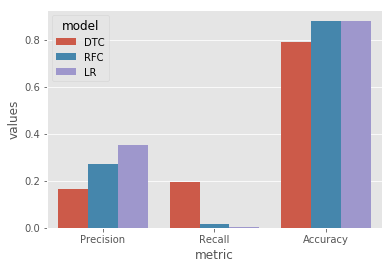

In [39]:
# Визуалищировать эти метрики всех моделей на одном графике (чтоб визуально сравнить)
# Возможно вас удивит качество! Но задача подобрана специально ;) Такое качество тоже бывает

## Your Code Here
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.barplot(x="metric", y="values", hue="model", data=metrics)

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr_DTC, tpr_DTC, thresholds_DTC = roc_curve(y_test, predict_p_DTC[:,1])
fpr_RFC, tpr_RFC, thresholds_RFC = roc_curve(y_test, predict_p_RFC[:,1])
fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, predict_p_LR[:,1])

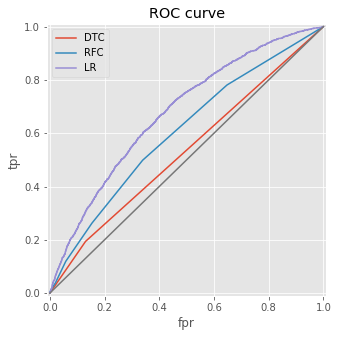

In [41]:
# Потроить roc-кривые всех можелей на одном графике
# Вывести roc_auc каждой моделе
# Подпишите оси и линии

from matplotlib import pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(fpr_DTC, tpr_DTC)
plt.plot(fpr_RFC, tpr_RFC)
plt.plot(fpr_LR, tpr_LR)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
plt.legend(['DTC', 'RFC', 'LR'])

In [42]:
from sklearn.cross_validation import cross_val_score
# Сделать k-fold (10 фолдов) кросс-валидацию каждой модели
# И посчитать средний roc_auc

rfc = RandomForestClassifier()
print(np.mean(cross_val_score(
    rfc,
    X_Train,
    y_Train,
    scoring='roc_auc',
    cv=10)))

dtc = DecisionTreeClassifier()
print(np.mean(cross_val_score(
    dtc,
    X_Train,
    y_Train,
    scoring='roc_auc',
    cv=10)))

lr = LogisticRegression()
print(np.mean(cross_val_score(
    lr,
    X_Train,
    y_Train,
    scoring='roc_auc',
    cv=10)))

0.5978489844549969
0.5205276153358949
0.6691186589669968


In [44]:
# Взять лучшую модель и сделать предсказания (с вероятностями (!!!)) для test выборки

model_LR = LogisticRegression()
model_LR.fit(X_Train, y_Train)
predict_LR = model_LR.predict(X_test)
predict_p_LR = model_LR.predict_proba(X_test)

C:\Users\khuhlax\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


0.6773858879722102

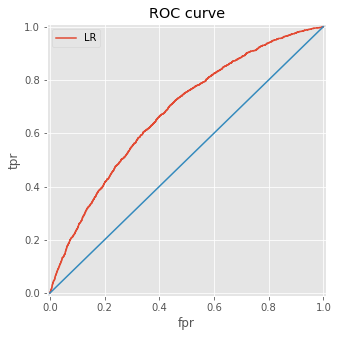

In [45]:
# Померить roc_auc на тесте
# Вывести текстом и на графике =)

plt.figure(figsize=(5, 5))
plt.plot(fpr_LR, tpr_LR)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
plt.legend(['LR'])
roc_auc_score(y_test, predict_p_LR[:,1])
## Your Code Here

### Больше обязательных заданий нет, но ниже вы можете провести исследование, поиграться с данными
### Это возможность написать код, который я посмотрю и в случае чего откомметирую. ;)
### Это не оценивается и остается на ваше усмотрение. Просто дополнительная возможность

In [ ]:
### И далее ;)